In [9]:
import pandas as pd
from Preprocess import * 
from FeatureExtraction import *
from plotting import *
from tqdm import tqdm 

In [22]:
df = pd.read_csv('data/WELFake_Dataset.csv')

df.drop(df.columns[0], axis=1, inplace=True)
df.dropna(inplace=True)

df = df.sample(n=5000, random_state=42)

print(df['label'].value_counts())

X=df.drop(['label'],axis=1)
y=df['label']
print(X.shape)
print(y.shape)

1    7561
0    7439
Name: label, dtype: int64
(15000, 2)
(15000,)


In [3]:
# df = pd.read_csv('data/news_articles.csv')

# df.dropna(inplace=True)
# df.drop(df[df['language'] != 'english'].index,inplace=True)
# df=df.drop(['published','main_img_url','type','language','title_without_stopwords','text_without_stopwords'],axis=1)


# print(df['label'].value_counts())

# X=df.drop(['label'],axis=1)
# y=df['label']
# print(X.shape)
# print(y.shape)


In [11]:
X.head()

,title,text
54359,Live at Truthdig: Robert Scheer and Thomas Fra...,Live at Truthdig: Robert Scheer and Thomas Fra...
6993,The Mirage of a Return to Manufacturing Greatn...,"Half a century ago, harvesting California’s 2...."
28912,British PM expected to offer to fill post-Brex...,(Reuters) - The British government has told Ge...
65965,Checkmating Obama,Originally published by the Jerusalem Post . \...
2307,Thirty-eight injured in police charges in Cata...,MADRID (Reuters) - Emergency services have att...


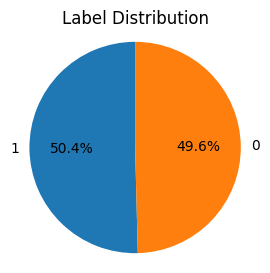

In [23]:
import matplotlib.pyplot as plt

label_counts = y.value_counts()

plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Label Distribution')
plt.show()


In [24]:
X['preprocessed_text'] = preprocess_text(X['text'])
print(X['preprocessed_text'].head(3))


54359    live truthdig robert scheer thomas frank talk ...
6993     half century ago harvesting california million...
28912    reuters british government told german chancel...
Name: preprocessed_text, dtype: object


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X['preprocessed_text'], y, test_size=0.2, random_state=42)

ngram_ranges = [(1, 1), (2, 2), (3, 3)]

classifiers = [
    LogisticRegression(),
    MultinomialNB(),
    RandomForestClassifier(),
    SVC()
]

for ngram_range in tqdm(ngram_ranges):
    metrics_dict = {}
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    for classifier in tqdm(classifiers):
        classifier_name = classifier.__class__.__name__
        classifier_metrics = []

        classifier.fit(X_train_tfidf, y_train)
        y_pred = classifier.predict(X_test_tfidf)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        classifier_metrics.extend([accuracy, precision, recall, f1])
        metrics_dict[classifier_name] = classifier_metrics

    print(f"{ngram_range}-gram")
    for classifier_name, classifier_metrics in metrics_dict.items():
        print(f"{classifier_name}: {classifier_metrics}")


(1, 1)-gram
LogisticRegression: [0.918, 0.909323116219668, 0.9319371727748691, 0.92049127343245]
MultinomialNB: [0.839, 0.8767123287671232, 0.7958115183246073, 0.8343053173241851]
RandomForestClassifier: [0.8993333333333333, 0.9027595269382391, 0.8992146596858639, 0.900983606557377]
SVC: [0.937, 0.9344581440622972, 0.9424083769633508, 0.93841642228739]


KeyboardInterrupt: 

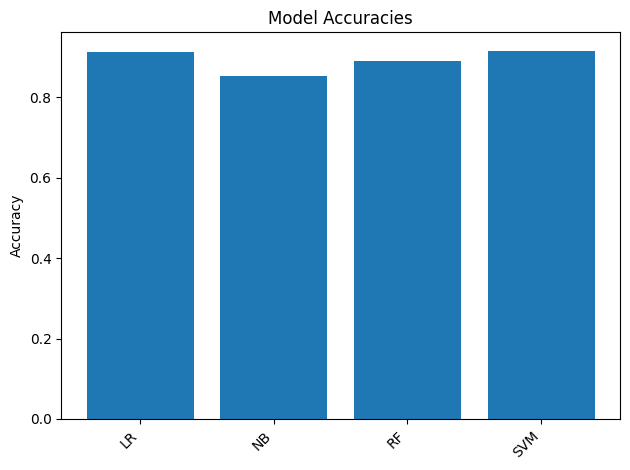

<Figure size 300x300 with 0 Axes>

In [8]:
plot_accuracy_graph(["LR","NB","RF","SVM"],[0.912,0.854,0.891,0.916])

In [7]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

X = X['preprocessed_text']
y = np.array(y)

ngram_ranges = [(1, 1), (2, 2), (3, 3)]

classifiers = [
    LogisticRegression(max_iter=1000),
    MultinomialNB(),
    RandomForestClassifier(),
    SVC()
]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

metrics_dict = {}

for classifier in tqdm(classifiers):
    classifier_name = classifier.__class__.__name__
    classifier_metrics = []

    for ngram_range in tqdm(ngram_ranges):
        vectorizer = TfidfVectorizer(ngram_range=ngram_range)
        X_tfidf = vectorizer.fit_transform(X)

        accuracies = []
        for train_index, test_index in kf.split(X_tfidf):
            X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
            y_train, y_test = y[train_index], y[test_index]

            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        mean_accuracy = np.mean(accuracies)
        classifier_metrics.append(mean_accuracy)

    metrics_dict[classifier_name] = classifier_metrics

for ngram_range in ngram_ranges:
    print(f"{ngram_range}-gram")
    for classifier_name, classifier_metrics in metrics_dict.items():
        print(f"{classifier_name}: {classifier_metrics}")


KeyboardInterrupt: 

In [25]:
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

sentences = [text.split() for text in X['preprocessed_text']]
word2vec_model = Word2Vec(sentences, min_count=1, vector_size=100)

X_train, X_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=42)

ngram_ranges = [(1, 1), (2, 2), (3, 3)]

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    SVC()
]

metrics_dict = {}

for ngram_range in ngram_ranges:
    ngram_metrics = {}
    
    #get vectors for each word in the sentence and average them using word2vec
    X_train_word_vectors = np.array([np.mean([word2vec_model.wv[w] for w in words if w in word2vec_model.wv] or [np.zeros(100)], axis=0) for words in X_train])
    X_test_word_vectors = np.array([np.mean([word2vec_model.wv[w] for w in words if w in word2vec_model.wv] or [np.zeros(100)], axis=0) for words in X_test])
    
    X_train_normalized = preprocessing.normalize(X_train_word_vectors, norm='l2')
    X_test_normalized = preprocessing.normalize(X_test_word_vectors, norm='l2')

    for classifier in classifiers:
        classifier_name = classifier.__class__.__name__
        classifier_metrics = []

        classifier.fit(X_train_normalized, y_train)
        y_pred = classifier.predict(X_test_normalized)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        classifier_metrics.extend([accuracy, precision, recall, f1])
        ngram_metrics[classifier_name] = classifier_metrics

    metrics_dict[ngram_range] = ngram_metrics

for ngram_range, ngram_metrics in metrics_dict.items():
    print(f"n-gram range {ngram_range}:")
    for classifier_name, classifier_metrics in ngram_metrics.items():
        print(f"{classifier_name}: {classifier_metrics}")

n-gram range (1, 1):
LogisticRegression: [0.8653333333333333, 0.8697368421052631, 0.8651832460732984, 0.8674540682414699]
RandomForestClassifier: [0.8753333333333333, 0.8651898734177215, 0.8946335078534031, 0.8796653796653797]
SVC: [0.8963333333333333, 0.8964169381107492, 0.900523560209424, 0.8984655566438131]
n-gram range (2, 2):
LogisticRegression: [0.8653333333333333, 0.8697368421052631, 0.8651832460732984, 0.8674540682414699]
RandomForestClassifier: [0.8726666666666667, 0.8687258687258688, 0.8835078534031413, 0.8760545100584036]
SVC: [0.8963333333333333, 0.8964169381107492, 0.900523560209424, 0.8984655566438131]
n-gram range (3, 3):
LogisticRegression: [0.8653333333333333, 0.8697368421052631, 0.8651832460732984, 0.8674540682414699]
RandomForestClassifier: [0.873, 0.8683365446371226, 0.8848167539267016, 0.8764991896272286]
SVC: [0.8963333333333333, 0.8964169381107492, 0.900523560209424, 0.8984655566438131]


In [15]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in X['preprocessed_text']]

sentence_len=20
embedded_doc = pad_sequences(onehot_repr,padding='pre',maxlen=sentence_len)

embedding_vec_feature=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vec_feature,input_length=sentence_len))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())




X_f=np.array(embedded_doc)
y_f=np.array(y)
print(X_f.shape)
print(y_f.shape)


X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.2, random_state=42)

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None
(1500, 20)
(1500,)
Epoch 1/10
19/19 [========